## 集成学习案例二 （蒸汽量预测）

### 背景介绍

火力发电的基本原理是：燃料在燃烧时加热水生成蒸汽，蒸汽压力推动汽轮机旋转，然后汽轮机带动发电机旋转，产生电能。在这一系列的能量转化中，影响发电效率的核心是锅炉的燃烧效率，即燃料燃烧加热水产生高温高压蒸汽。锅炉的燃烧效率的影响因素很多，包括锅炉的可调参数，如燃烧给量，一二次风，引风，返料风，给水水量；以及锅炉的工况，比如锅炉床温、床压，炉膛温度、压力，过热器的温度等。我们如何使用以上的信息，根据锅炉的工况，预测产生的蒸汽量，来为我国的工业届的产量预测贡献自己的一份力量呢？

所以，该案例是使用以上工业指标的特征，进行蒸汽量的预测问题。由于信息安全等原因，我们使用的是经脱敏后的锅炉传感器采集的数据（采集频率是分钟级别）。

### 数据信息
数据分成训练数据（train.txt）和测试数据（test.txt），其中字段”V0”-“V37”，这38个字段是作为特征变量，”target”作为目标变量。我们需要利用训练数据训练出模型，预测测试数据的目标变量。

### 评价指标
最终的评价指标为均方误差MSE，即：
$$Score = \frac{1}{n} \sum_1 ^n (y_i - y ^*)^2$$

### 导入package

In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns

# 模型
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score,cross_val_predict,KFold
from sklearn.metrics import make_scorer,mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures,MinMaxScaler,StandardScaler

### 加载数据

In [2]:
data_train = pd.read_csv('train.txt',sep = '\t')
data_test = pd.read_csv('test.txt',sep = '\t')

In [3]:
#合并训练数据和测试数据
data_train["oringin"]="train"
data_test["oringin"]="test"
data_all=pd.concat([data_train,data_test],axis=0,ignore_index=True)
#显示前5条数据
data_all.head()

,V0,V1,V10,V11,V12,V13,V14,V15,V16,V17,...,V36,V37,V4,V5,V6,V7,V8,V9,oringin,target
0,0.566,0.016,-0.940,-0.307,-0.073,0.550,-0.484,0.000,-1.707,-1.162,...,-2.608,-3.508,0.452,-0.901,-1.812,-2.360,-0.436,-2.114,train,0.175
1,0.968,0.437,0.188,-0.455,-0.134,1.109,-0.488,0.000,-0.977,-1.162,...,-0.335,-0.730,0.194,-0.893,-1.566,-2.360,0.332,-2.114,train,0.676
2,1.013,0.568,0.874,-0.051,-0.072,0.767,-0.493,-0.212,-0.618,-0.897,...,0.765,-0.589,0.112,-0.797,-1.367,-2.360,0.396,-2.114,train,0.633
3,0.733,0.368,0.011,0.102,-0.014,0.769,-0.371,-0.162,-0.429,-0.897,...,0.333,-0.112,0.599,-0.679,-1.200,-2.086,0.403,-2.114,train,0.206
4,0.684,0.638,-0.251,0.570,0.199,-0.349,-0.342,-0.138,-0.391,-0.897,...,-0.280,-0.028,0.337,-0.454,-1.073,-2.086,0.314,-2.114,train,0.384


### 探索数据分布

这里因为是传感器的数据，即连续变量，所以使用 kdeplot(核密度估计图) 进行数据的初步分析，即EDA。

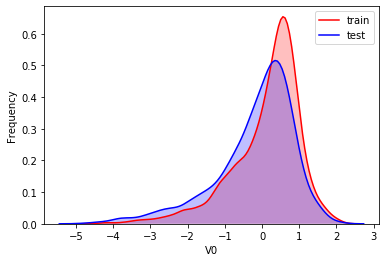

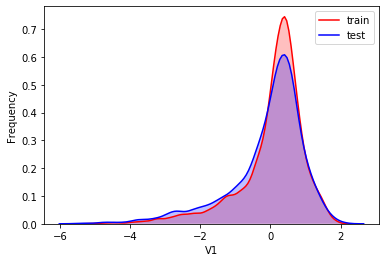

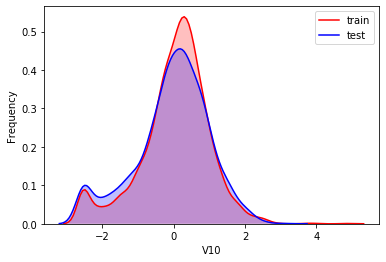

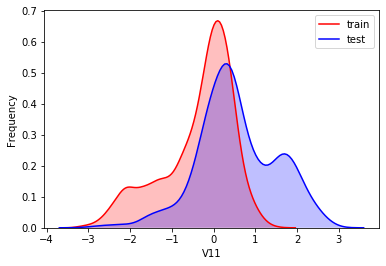

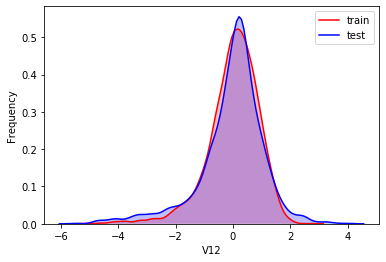

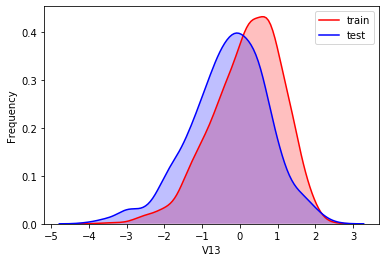

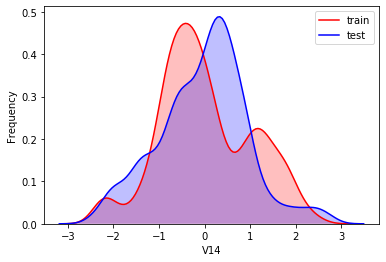

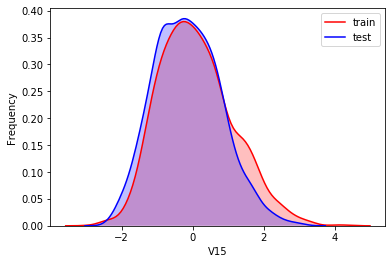

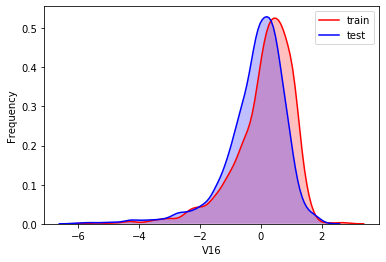

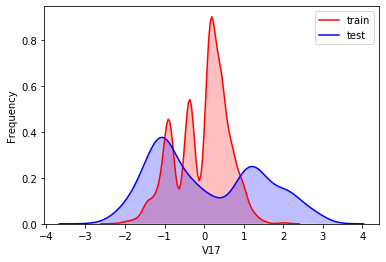

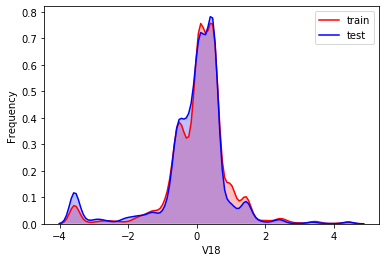

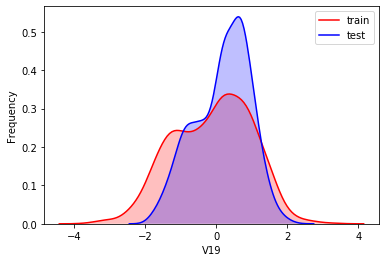

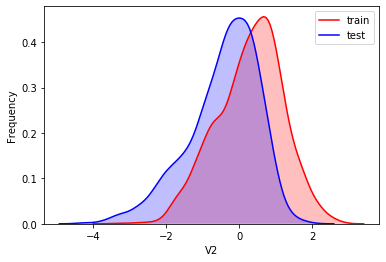

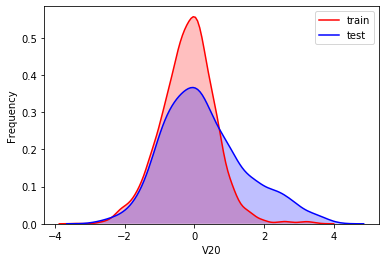

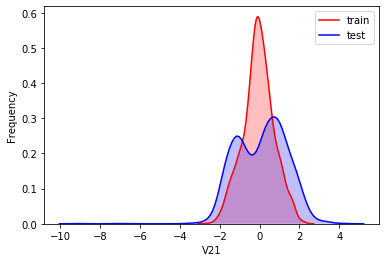

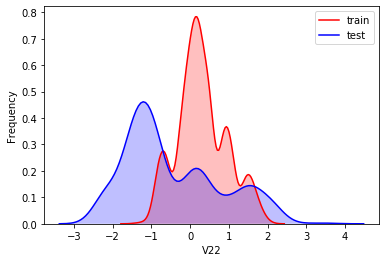

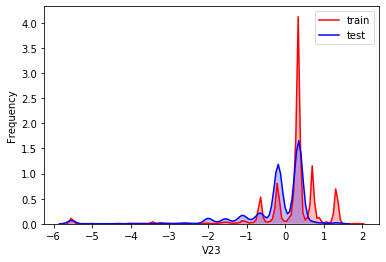

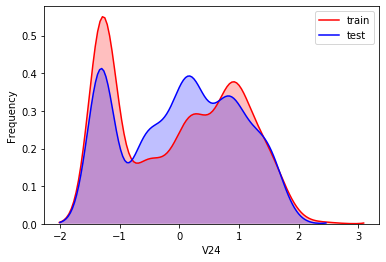

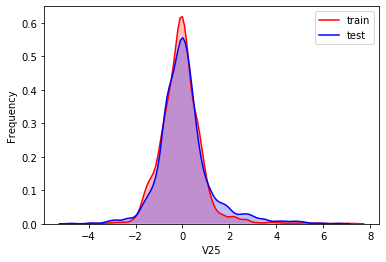

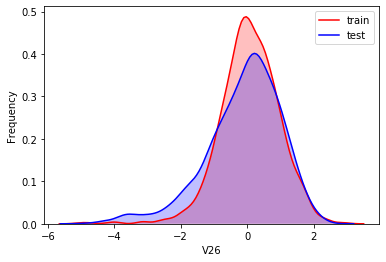

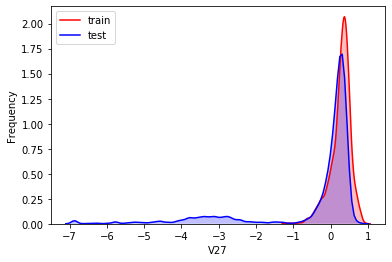

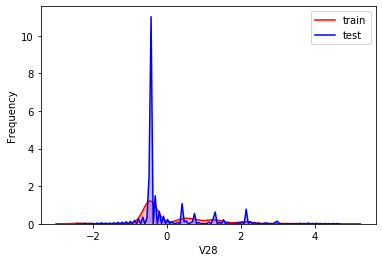

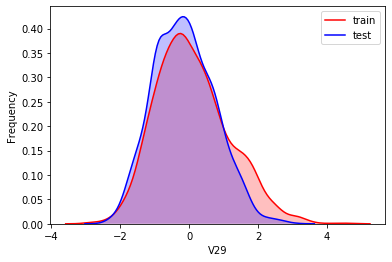

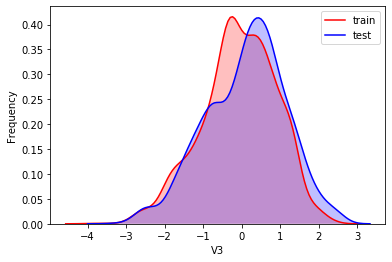

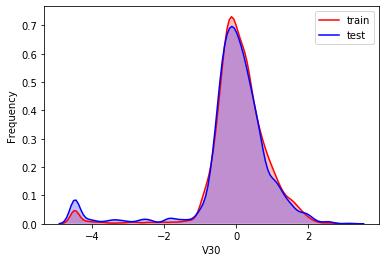

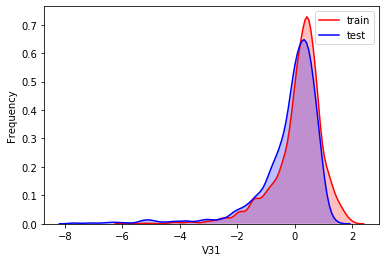

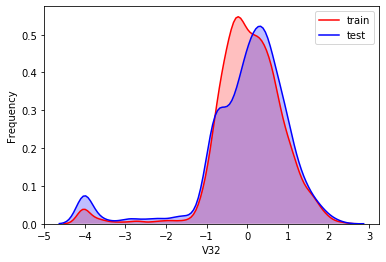

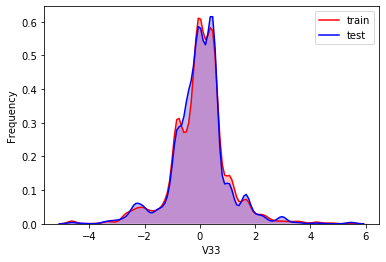

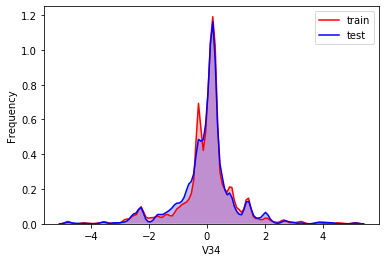

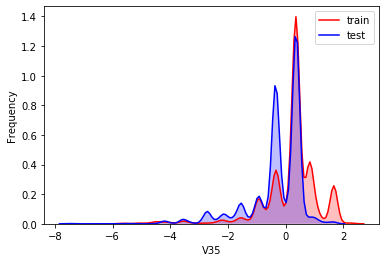

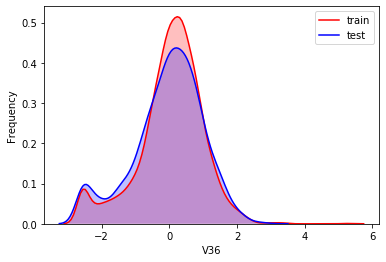

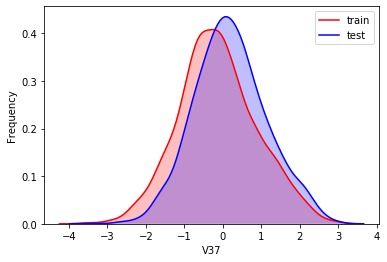

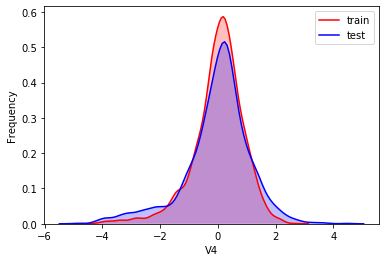

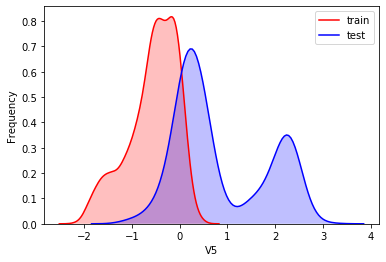

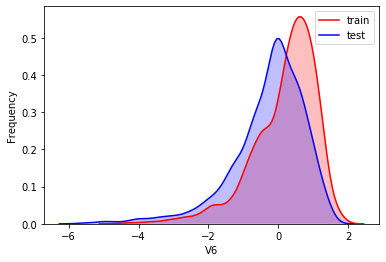

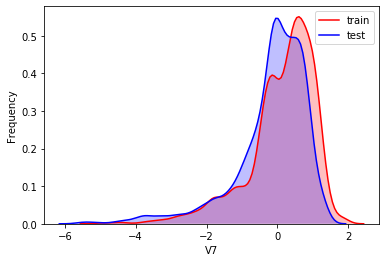

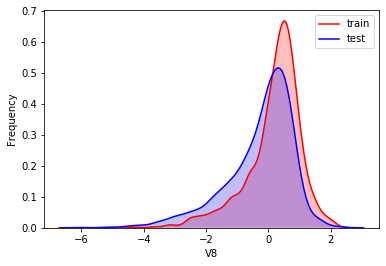

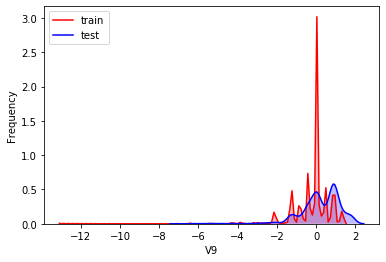

In [4]:
for column in data_all.columns[0:-2]:
    #核密度估计(kernel density estimation)是在概率论中用来估计未知的密度函数，属于非参数检验方法之一。通过核密度估计图可以比较直观的看出数据样本本身的分布特征。
    g = sns.kdeplot(data_all[column][(data_all["oringin"] == "train")], color="Red", shade = True)
    g = sns.kdeplot(data_all[column][(data_all["oringin"] == "test")], ax =g, color="Blue", shade= True)
    g.set_xlabel(column)
    g.set_ylabel("Frequency")
    g = g.legend(["train","test"])
    plt.show()

从以上的图中可以看出特征"V5","V9","V11","V17","V22","V28"中训练集数据分布和测试集数据分布不均，所以我们删除这些特征数据

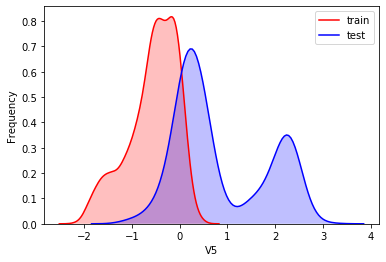

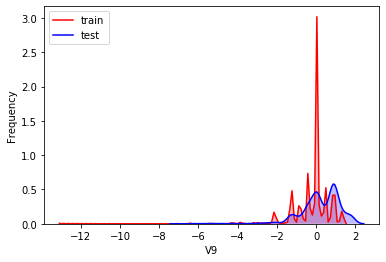

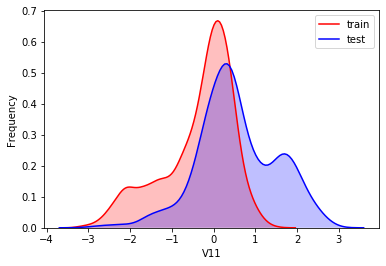

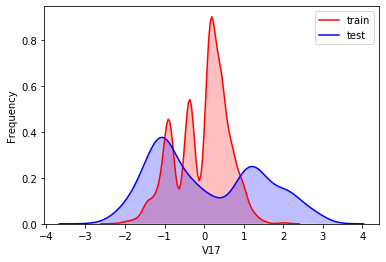

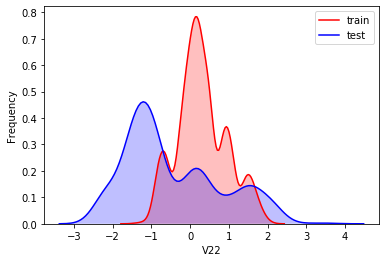

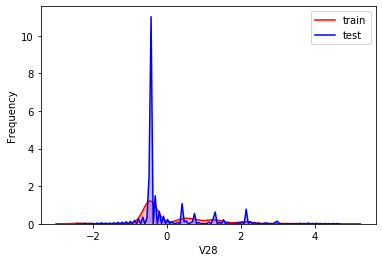

In [5]:
for column in ["V5","V9","V11","V17","V22","V28"]:
    g = sns.kdeplot(data_all[column][(data_all["oringin"] == "train")], color="Red", shade = True)
    g = sns.kdeplot(data_all[column][(data_all["oringin"] == "test")], ax =g, color="Blue", shade= True)
    g.set_xlabel(column)
    g.set_ylabel("Frequency")
    g = g.legend(["train","test"])
    plt.show()

data_all.drop(["V5","V9","V11","V17","V22","V28"],axis=1,inplace=True)

查看特征之间的相关性（相关程度）

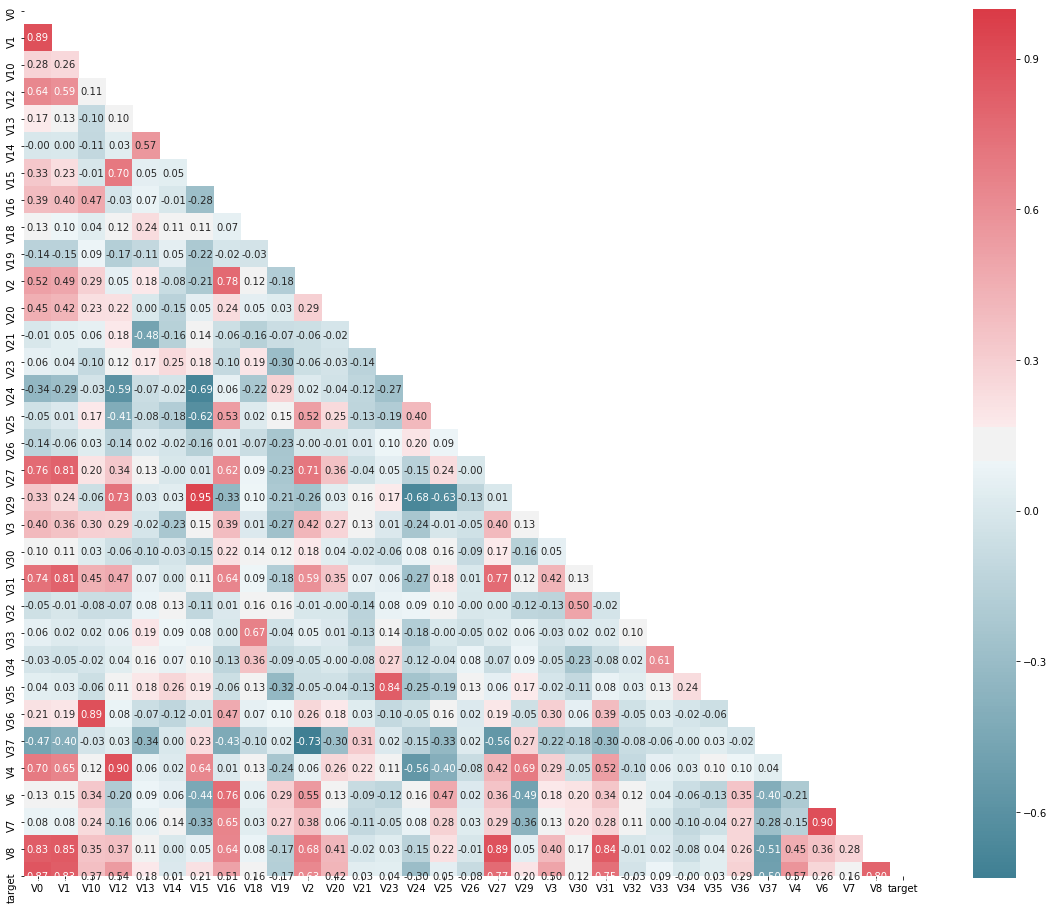

In [6]:
data_train1=data_all[data_all["oringin"]=="train"].drop("oringin",axis=1)
plt.figure(figsize=(20, 16))  # 指定绘图对象宽度和高度
colnm = data_train1.columns.tolist()  # 列表头
mcorr = data_train1[colnm].corr(method="spearman")  # 相关系数矩阵，即给出了任意两个变量之间的相关系数
mask = np.zeros_like(mcorr, dtype=np.bool)  # 构造与mcorr同维数矩阵 为bool型
mask[np.triu_indices_from(mask)] = True  # 角分线右侧为True
cmap = sns.diverging_palette(220, 10, as_cmap=True)  # 返回matplotlib colormap对象，调色板
g = sns.heatmap(mcorr, mask=mask, cmap=cmap, square=True, annot=True, fmt='0.2f')  # 热力图（看两两相似度）
plt.show()

进行降维操作，即将相关性的绝对值小于阈值的特征进行删除

In [7]:
threshold = 0.1
corr_matrix = data_train1.corr().abs()
drop_col=corr_matrix[corr_matrix["target"]<threshold].index
data_all.drop(drop_col,axis=1,inplace=True)

进行归一化操作

In [8]:
cols_numeric=list(data_all.columns)
cols_numeric.remove("oringin")
def scale_minmax(col):
    return (col-col.min())/(col.max()-col.min())
scale_cols = [col for col in cols_numeric if col!='target']
data_all[scale_cols] = data_all[scale_cols].apply(scale_minmax,axis=0)
data_all[scale_cols].describe()

,V0,V1,V10,V12,V13,V15,V16,V18,V19,V2,...,V3,V30,V31,V35,V36,V37,V4,V6,V7,V8
count,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,...,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000
mean,0.694172,0.721357,0.348518,0.578507,0.612372,0.402251,0.679294,0.446542,0.519158,0.602300,...,0.603139,0.589459,0.792709,0.762873,0.332385,0.545795,0.523743,0.748823,0.745740,0.715607
std,0.144198,0.131443,0.134882,0.105088,0.149835,0.138561,0.112095,0.124627,0.140166,0.140628,...,0.152462,0.130786,0.102976,0.102037,0.127456,0.150356,0.106430,0.132560,0.132577,0.118105
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.626676,0.679416,0.284327,0.532892,0.519928,0.299016,0.629414,0.399302,0.414436,0.514414,...,0.503888,0.550092,0.761816,0.727273,0.270584,0.445647,0.478182,0.683324,0.696938,0.664934
50%,0.729488,0.752497,0.366469,0.591635,0.627809,0.391437,0.700258,0.456256,0.540294,0.617072,...,0.614270,0.594428,0.815055,0.800020,0.347056,0.539317,0.535866,0.774125,0.771974,0.742884
75%,0.790195,0.799553,0.432965,0.641971,0.719958,0.489954,0.753279,0.501745,0.623125,0.700464,...,0.710474,0.650798,0.852229,0.800020,0.414861,0.643061,0.585036,0.842259,0.836405,0.790835
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 特征工程

绘图显示Box-Cox变换对数据分布影响，Box-Cox用于连续的响应变量不满足正态分布的情况。在进行Box-Cox变换之后，可以一定程度上减小不可观测的误差和预测变量的相关性。

对于quantitle-quantile(q-q)图，可参考： https://blog.csdn.net/u012193416/article/details/83210790

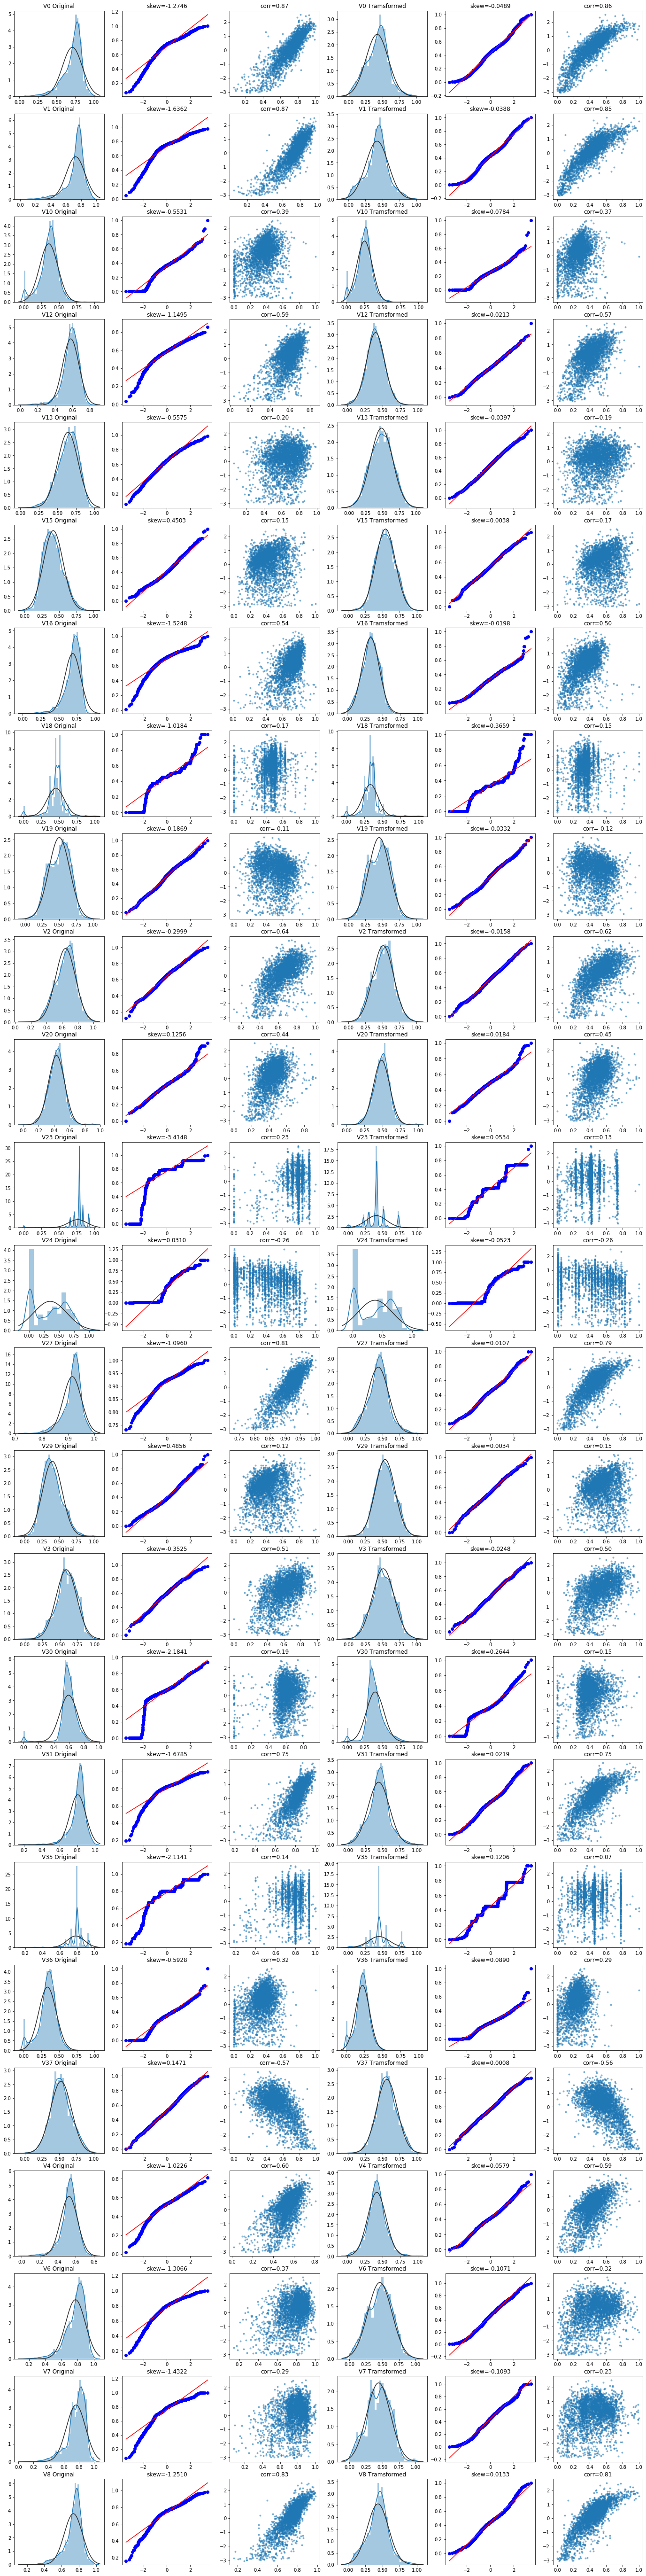

In [9]:
fcols = 6
frows = len(cols_numeric)-1
plt.figure(figsize=(4*fcols,4*frows))
i=0

for var in cols_numeric:
    if var!='target':
        dat = data_all[[var, 'target']].dropna()
        
        i+=1
        plt.subplot(frows,fcols,i)
        sns.distplot(dat[var] , fit=stats.norm);
        plt.title(var+' Original')
        plt.xlabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        _=stats.probplot(dat[var], plot=plt)
        plt.title('skew='+'{:.4f}'.format(stats.skew(dat[var])))
        plt.xlabel('')
        plt.ylabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        plt.plot(dat[var], dat['target'],'.',alpha=0.5)
        plt.title('corr='+'{:.2f}'.format(np.corrcoef(dat[var], dat['target'])[0][1]))
 
        i+=1
        plt.subplot(frows,fcols,i)
        trans_var, lambda_var = stats.boxcox(dat[var].dropna()+1)
        trans_var = scale_minmax(trans_var)      
        sns.distplot(trans_var , fit=stats.norm);
        plt.title(var+' Tramsformed')
        plt.xlabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        _=stats.probplot(trans_var, plot=plt)
        plt.title('skew='+'{:.4f}'.format(stats.skew(trans_var)))
        plt.xlabel('')
        plt.ylabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        plt.plot(trans_var, dat['target'],'.',alpha=0.5)
        plt.title('corr='+'{:.2f}'.format(np.corrcoef(trans_var,dat['target'])[0][1]))

count    2888.000000
mean        0.126353
std         0.983966
min        -3.044000
25%        -0.350250
50%         0.313000
75%         0.793250
max         2.538000
Name: target, dtype: float64


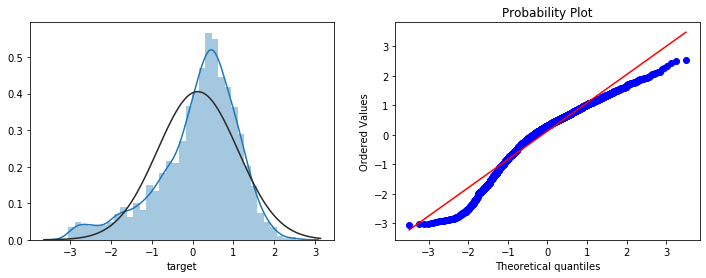

In [10]:
# 进行Box-Cox变换
cols_transform=data_all.columns[0:-2]
for col in cols_transform:   
    # transform column
    data_all.loc[:,col], _ = stats.boxcox(data_all.loc[:,col]+1)
print(data_all.target.describe())
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(data_all.target.dropna() , fit=stats.norm);
plt.subplot(1,2,2)
_=stats.probplot(data_all.target.dropna(), plot=plt)

使用对数变换target目标值提升特征数据的正太性
可参考：https://www.zhihu.com/question/22012482

count    2888.000000
mean        1.129957
std         0.394110
min         0.291057
25%         0.867609
50%         1.135315
75%         1.379382
max         2.798463
Name: target, dtype: float64


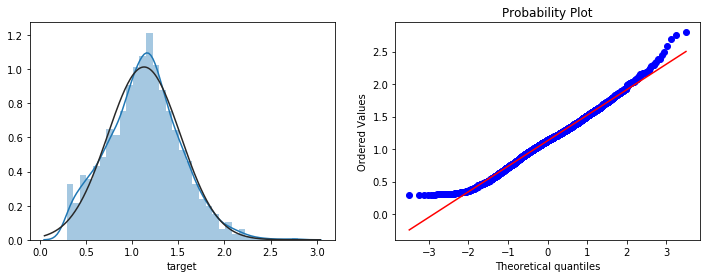

In [11]:
sp = data_train.target
data_train.target1 =np.power(1.5,sp)
print(data_train.target1.describe())

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(data_train.target1.dropna(),fit=stats.norm);
plt.subplot(1,2,2)
_=stats.probplot(data_train.target1.dropna(), plot=plt)

### 模型构建以及集成学习

构建训练集和测试集

In [12]:
# function to get training samples
def get_training_data():
    # extract training samples
    from sklearn.model_selection import train_test_split
    df_train = data_all[data_all["oringin"]=="train"]
    df_train["label"]=data_train.target1
    # split SalePrice and features
    y = df_train.target
    X = df_train.drop(["oringin","target","label"],axis=1)
    X_train,X_valid,y_train,y_valid=train_test_split(X,y,test_size=0.3,random_state=100)
    return X_train,X_valid,y_train,y_valid

# extract test data (without SalePrice)
def get_test_data():
    df_test = data_all[data_all["oringin"]=="test"].reset_index(drop=True)
    return df_test.drop(["oringin","target"],axis=1)

rmse、mse的评价函数

In [13]:
from sklearn.metrics import make_scorer
# metric for evaluation
def rmse(y_true, y_pred):
    diff = y_pred - y_true
    sum_sq = sum(diff**2)    
    n = len(y_pred)   
    return np.sqrt(sum_sq/n)

def mse(y_ture,y_pred):
    return mean_squared_error(y_ture,y_pred)

# scorer to be used in sklearn model fitting
rmse_scorer = make_scorer(rmse, greater_is_better=False) 

#输入的score_func为记分函数时，该值为True（默认值）；输入函数为损失函数时，该值为False
mse_scorer = make_scorer(mse, greater_is_better=False)


寻找离群值，并删除

In [14]:
# function to detect outliers based on the predictions of a model
def find_outliers(model, X, y, sigma=3):

    # predict y values using model
    model.fit(X,y)
    y_pred = pd.Series(model.predict(X), index=y.index)
        
    # calculate residuals between the model prediction and true y values
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()

    # calculate z statistic, define outliers to be where |z|>sigma
    z = (resid - mean_resid)/std_resid    
    outliers = z[abs(z)>sigma].index
    
    # print and plot the results
    print('R2=',model.score(X,y))
    print('rmse=',rmse(y, y_pred))
    print("mse=",mean_squared_error(y,y_pred))
    print('---------------------------------------')

    print('mean of residuals:',mean_resid)
    print('std of residuals:',std_resid)
    print('---------------------------------------')

    print(len(outliers),'outliers:')
    print(outliers.tolist())

    plt.figure(figsize=(15,5))
    ax_131 = plt.subplot(1,3,1)
    plt.plot(y,y_pred,'.')
    plt.plot(y.loc[outliers],y_pred.loc[outliers],'ro')
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('y')
    plt.ylabel('y_pred');

    ax_132=plt.subplot(1,3,2)
    plt.plot(y,y-y_pred,'.')
    plt.plot(y.loc[outliers],y.loc[outliers]-y_pred.loc[outliers],'ro')
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('y')
    plt.ylabel('y - y_pred');

    ax_133=plt.subplot(1,3,3)
    z.plot.hist(bins=50,ax=ax_133)
    z.loc[outliers].plot.hist(color='r',bins=50,ax=ax_133)
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('z')
    
    return outliers

R2= 0.8766692300840108
rmse= 0.3490086770200251
mse= 0.12180705663526846
---------------------------------------
mean of residuals: 1.4843258844815303e-16
std of residuals: 0.34909505461744217
---------------------------------------
22 outliers:
[2655, 2159, 1164, 2863, 1145, 2697, 2528, 2645, 691, 1085, 1874, 2647, 884, 2696, 2668, 1310, 1901, 1458, 2769, 2002, 2669, 1972]


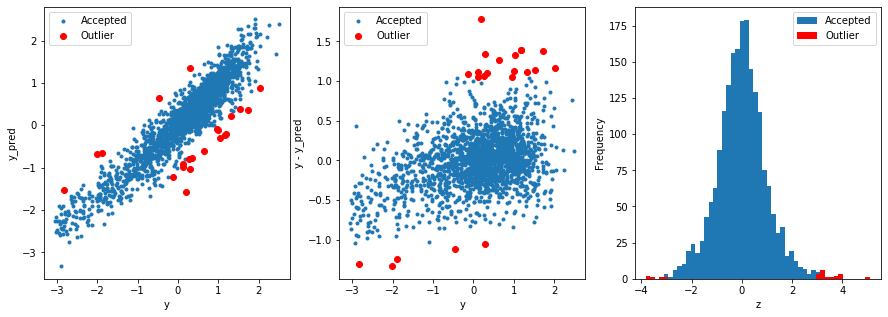

In [15]:
# get training data
X_train, X_valid,y_train,y_valid = get_training_data()
test=get_test_data()

# find and remove outliers using a Ridge model
outliers = find_outliers(Ridge(), X_train, y_train)
X_outliers=X_train.loc[outliers]
y_outliers=y_train.loc[outliers]
X_t=X_train.drop(outliers)
y_t=y_train.drop(outliers)

进行模型的训练

In [16]:
def get_trainning_data_omitoutliers():
    #获取训练数据省略异常值
    y=y_t.copy()
    X=X_t.copy()
    return X,y

In [17]:
def train_model(model, param_grid=[], X=[], y=[], 
                splits=5, repeats=5):

    # 获取数据
    if len(y)==0:
        X,y = get_trainning_data_omitoutliers()
        
    # 交叉验证
    rkfold = RepeatedKFold(n_splits=splits, n_repeats=repeats)
    
    # 网格搜索最佳参数
    if len(param_grid)>0:
        gsearch = GridSearchCV(model, param_grid, cv=rkfold,
                               scoring="neg_mean_squared_error",
                               verbose=1, return_train_score=True)

        # 训练
        gsearch.fit(X,y)

        # 最好的模型
        model = gsearch.best_estimator_        
        best_idx = gsearch.best_index_

        # 获取交叉验证评价指标
        grid_results = pd.DataFrame(gsearch.cv_results_)
        cv_mean = abs(grid_results.loc[best_idx,'mean_test_score'])
        cv_std = grid_results.loc[best_idx,'std_test_score']

    # 没有网格搜索  
    else:
        grid_results = []
        cv_results = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=rkfold)
        cv_mean = abs(np.mean(cv_results))
        cv_std = np.std(cv_results)
    
    # 合并数据
    cv_score = pd.Series({'mean':cv_mean,'std':cv_std})

    # 预测
    y_pred = model.predict(X)
    
    # 模型性能的统计数据        
    print('----------------------')
    print(model)
    print('----------------------')
    print('score=',model.score(X,y))
    print('rmse=',rmse(y, y_pred))
    print('mse=',mse(y, y_pred))
    print('cross_val: mean=',cv_mean,', std=',cv_std)
    
    # 残差分析与可视化
    y_pred = pd.Series(y_pred,index=y.index)
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()
    z = (resid - mean_resid)/std_resid    
    n_outliers = sum(abs(z)>3)
    outliers = z[abs(z)>3].index
    
    return model, cv_score, grid_results

In [18]:
# 定义训练变量存储数据
opt_models = dict()
score_models = pd.DataFrame(columns=['mean','std'])
splits=5
repeats=5

Fitting 25 folds for each of 23 candidates, totalling 575 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


----------------------
Ridge(alpha=0.25, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------
score= 0.8926884448727849
rmse= 0.32466407807582776
mse= 0.10540676359282722
cross_val: mean= 0.10890639745404394 , std= 0.007654061179739962


[Parallel(n_jobs=1)]: Done 575 out of 575 | elapsed:    2.7s finished


Text(0, 0.5, 'score')

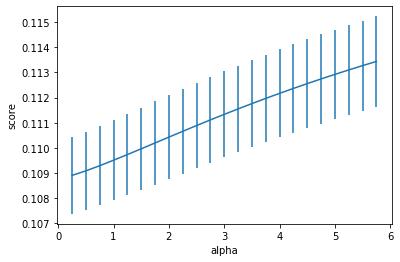

In [19]:
model = 'Ridge'  #可替换，见案例分析一的各种模型
opt_models[model] = Ridge() #可替换，见案例分析一的各种模型
alph_range = np.arange(0.25,6,0.25)
param_grid = {'alpha': alph_range}

opt_models[model],cv_score,grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(alph_range, abs(grid_results['mean_test_score']),
             abs(grid_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('alpha')
plt.ylabel('score')

In [20]:
# 预测函数
def model_predict(test_data,test_y=[]):
    i=0
    y_predict_total=np.zeros((test_data.shape[0],))
    for model in opt_models.keys():
        if model!="LinearSVR" and model!="KNeighbors":
            y_predict=opt_models[model].predict(test_data)
            y_predict_total+=y_predict
            i+=1
        if len(test_y)>0:
            print("{}_mse:".format(model),mean_squared_error(y_predict,test_y))
    y_predict_mean=np.round(y_predict_total/i,6)
    if len(test_y)>0:
        print("mean_mse:",mean_squared_error(y_predict_mean,test_y))
    else:
        y_predict_mean=pd.Series(y_predict_mean)
        return y_predict_mean

#### 进行模型的预测以及结果的保存

In [21]:
y_ = model_predict(test)
y_.to_csv('predict.txt',header = None,index = False)